# Classification with PyTorch/TensorFlow

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

## Part 1: Iris Classification

Iris Dataset contains 150 records of 3 different classes of irises. Each record contains 4 numeric parameters: sepal length/width and petal length/width. It is an example of a simple dataset, for which you do not need a powerful neural network.

### Getting the Dataset

Iris dataset is build into Scikit Learn, so we can easily get it:

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, Classes: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], Classes: ['setosa' 'versicolor' 'virginica']


### Visualize the Data

In many cases, it makes sense to visualize the data to see if they look separable - it would assure us that we should be able to build good classification model. Because we have a few features, we can build a series of pairwise 2D scatter plots, showing different classes by different dot colors. This can be automatically done by a package called **seaborn**:

In [2]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))

df

/home/kaleb/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


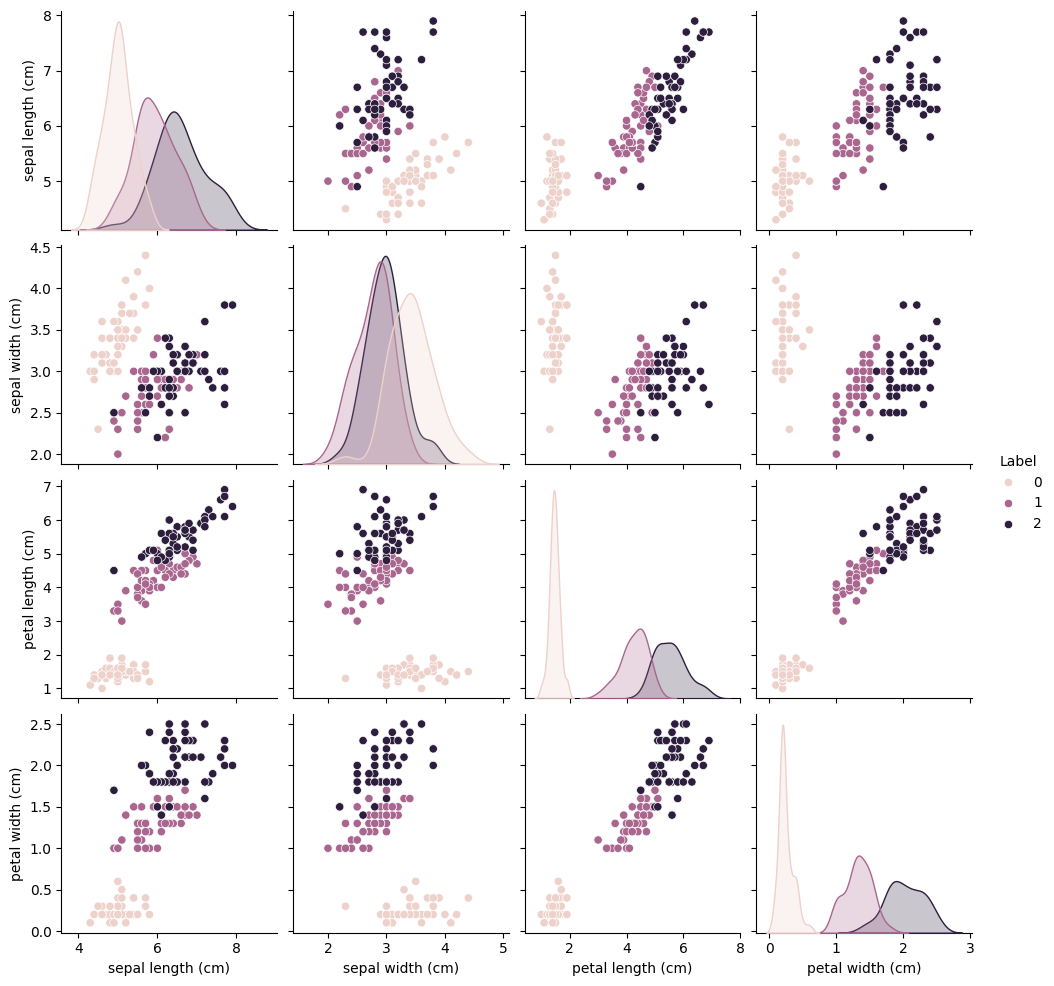

In [3]:
sns.pairplot(df,hue='Label')

### Normalize and Encode the Data

To prepare data to neural network training, we need to normalize inputs in the range [0..1]. This can be done either using plain `numpy` operations, or [Scikit Learn methods](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html).

Also, you need to decide if you want target label to be one-hot encoded or not. PyTorch and TensorFlow allow you feed in class number either as an integer (from 0 to N-1), or as one-hot encoded vector. When creating neural network structure, you need to specify loss function accordingly (eg. *sparse categorical crossentropy* for numeric representation, and *crossentropy loss* for one-hot encoding). One-hot encoding can also be [done using Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), or by using this piece of code:

```python
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]
``` 

# Kaleb Code
### Code to normalize and encode the data

In [4]:
import numpy as np

for col in df.columns:
    row_max = df[col].max()
    new_row = df[col] / row_max
    df[col] = new_row

In [5]:
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]

### Split the Data into Train and Test

Since we do not have separate train and test dataset, we need to split it intro train and test dataset [using Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [6]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.33, random_state=42)
print(f"Training values shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing values shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training values shape: (100, 4)
Training labels shape: (100,)
Testing values shape: (50, 4)
Testing labels shape: (50,)


### Define and Train Neural Network

Now you are ready to go, import your preferred framework, define the neural network and start training, observing the behavior of train and validation accuracy.

In [7]:
import matplotlib.pyplot as plt
import torch
torch.__version__
# Kaleb code
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
print(torch.cuda.get_device_name(0))

Using cuda device
NVIDIA GeForce GTX 1080


In [8]:
# Define the network
class NeuralNetwork(torch.nn.Module):
    def __init__(self,hidden_size=150,func=torch.nn.Sigmoid()):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,hidden_size)
        self.func = func
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.func = func
        self.fc3 = torch.nn.Linear(hidden_size,3)

    def forward(self,x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        x = self.func(x)
        x = self.fc3(x)
        return x

In [9]:
# Train the network
def train(net, train_vals, train_labs, test_vals, test_labs, batch_size = 50, epochs = 5, lr = 0.01):
    # Required for calculations
    size = len(train_vals)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Required for loss/acc
    loss_list = []
    acc_list = []
    
    for ep in range(epochs):
        for i in range(len(train_vals)):
            # Prediction and loss calculation
            pred = net(torch.tensor(train_vals[i], dtype=torch.float32))
            loss = loss_fn(pred, torch.tensor(train_labs[i]))
            

            # Back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    
        # Loss and Accuracy calculations
        
        correct = 0
        curr_loss = []
        for i in range(len(test_vals)):
            # Prediction and loss calculation
            pred = net(torch.tensor(test_vals[i], dtype=torch.float32))
            loss = loss_fn(pred, torch.tensor(train_labs[i]))
            curr_loss.append(loss.item())
            

            # Predicted vs actual
            class_pred = torch.argmax(pred, dim=0).item()
            correct += (class_pred == test_labs[i])

        # Average loss and epoch accuracy calculations
        acc = correct / len(test_labs)
        print(f"Epoch {ep} last loss: {loss.item()}, accuracy: {correct} / {len(test_labs)} = {acc}")
        loss_list.append(loss.item())
        acc_list.append(acc)
            
    return loss_list, acc_list
            

    
eris_net = NeuralNetwork()
loss_list, acc_list = train(eris_net, X_train, y_train, X_test, y_test)

Epoch 0 last loss: 0.45070239901542664, accuracy: 43 / 50 = 0.86
Epoch 1 last loss: 0.0517849363386631, accuracy: 41 / 50 = 0.82
Epoch 2 last loss: 0.027068020775914192, accuracy: 49 / 50 = 0.98
Epoch 3 last loss: 0.020910874009132385, accuracy: 49 / 50 = 0.98
Epoch 4 last loss: 0.21874432265758514, accuracy: 39 / 50 = 0.78


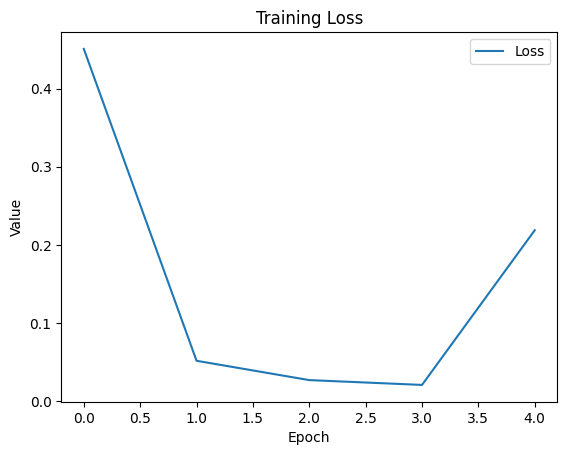

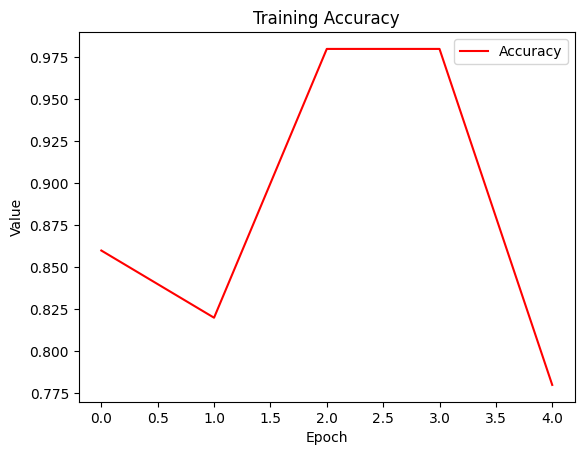

In [10]:
# Visualize train/validation accuracy graph
def graph_loss_acc(loss_list, acc_list):
    epochs = range(len(loss_list))
    plt.plot(epochs, loss_list, label='Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Loss')
    plt.show()
    plt.plot(epochs, acc_list, label='Accuracy',color='red')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Accuracy')
    plt.show()
    

graph_loss_acc(loss_list, acc_list)

In [11]:
# Test for curiosity
import random

random_index = random.randint(0, len(labels) - 1)
random_value = labels[random_index]

pred = torch.argmax(eris_net(torch.tensor(features[random_index], dtype=torch.float32)), axis=0)
print(f"Actual = {random_value} vs Predicted = {pred}")

Actual = 1 vs Predicted = 2


### Experiment

Now you can experiment with different network architectures to see how it affects the result. Try:
1. One-layer network with 3 neurons (equal to the number of classes)
1. Two-layer network with small/medium/large hidden layer
1. Using more layers

Make sure you observe overfitting when you are using rich model with lots of neurons (parameters).

In [12]:
# Experiment 1
class OneLayerNetwork(torch.nn.Module):
    def __init__(self,func=torch.nn.Sigmoid()):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,3)
        self.func = func
        self.fc2 = torch.nn.Linear(3,3)

    def forward(self,x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        return x

# Experiment 2
class TwoLayerNetwork(torch.nn.Module):
    def __init__(self,hidden_layer,func=torch.nn.Sigmoid()):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,hidden_layer)
        self.func = func
        self.fc2 = torch.nn.Linear(hidden_layer,hidden_layer)
        self.func = func
        self.fc3 = torch.nn.Linear(hidden_layer,3)
        

    def forward(self,x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        x = self.func(x)
        x = self.fc3(x)
        return x
        
# Experiment 3
class FiveLayerNetwork(torch.nn.Module):
    def __init__(self,hidden_layer=50,func=torch.nn.Sigmoid()):
        super().__init__()
        self.fc1 = torch.nn.Linear(4,hidden_layer)
        self.func = func
        self.fc2 = torch.nn.Linear(hidden_layer,hidden_layer)
        self.func = func
        self.fc3 = torch.nn.Linear(hidden_layer,3)
        

    def forward(self,x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        x = self.func(x)
        x = self.fc3(x)
        return x

Epoch 0 last loss: 0.6123433113098145, accuracy: 16 / 50 = 0.32
Epoch 1 last loss: 0.5436697006225586, accuracy: 35 / 50 = 0.7
Epoch 2 last loss: 0.5015543699264526, accuracy: 35 / 50 = 0.7
Epoch 3 last loss: 0.4855506420135498, accuracy: 38 / 50 = 0.76
Epoch 4 last loss: 0.46245077252388, accuracy: 43 / 50 = 0.86


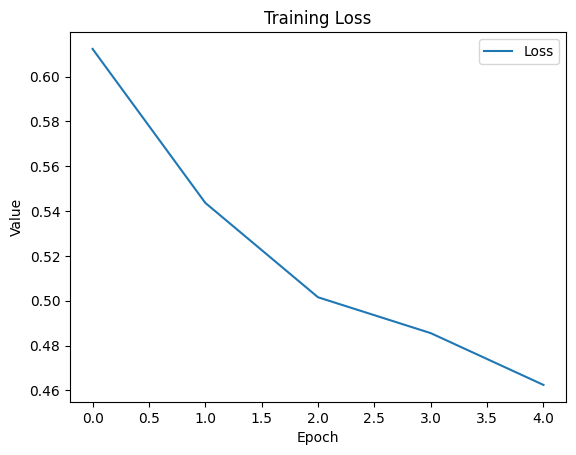

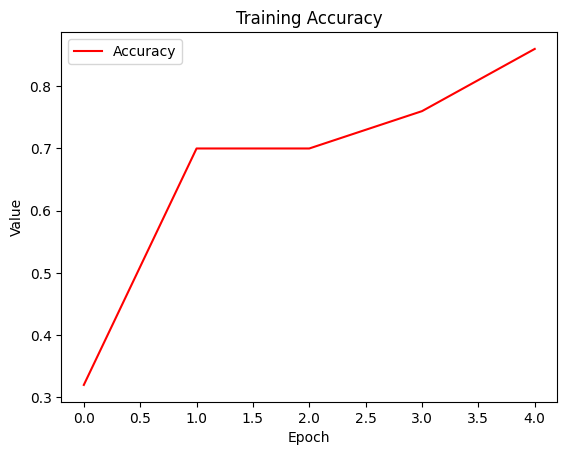

In [13]:
# Experiment 1
one_net = OneLayerNetwork()
one_loss_list, one_acc_list = train(one_net, X_train, y_train, X_test, y_test)
graph_loss_acc(one_loss_list, one_acc_list)

Epoch 0 last loss: 0.8080914616584778, accuracy: 16 / 50 = 0.32
Epoch 1 last loss: 0.5413557291030884, accuracy: 35 / 50 = 0.7
Epoch 2 last loss: 0.4600095748901367, accuracy: 44 / 50 = 0.88
Epoch 3 last loss: 0.3223350942134857, accuracy: 49 / 50 = 0.98
Epoch 4 last loss: 0.18892134726047516, accuracy: 49 / 50 = 0.98


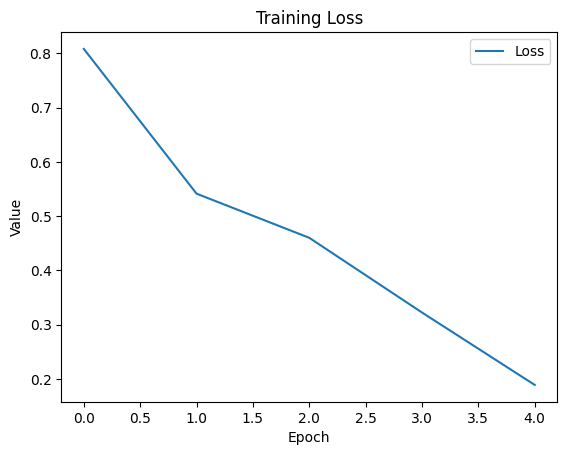

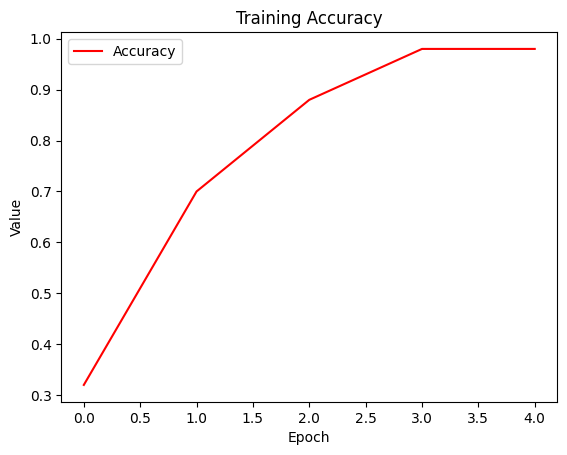

In [14]:
# Experiment 2 a
two_net = TwoLayerNetwork(hidden_layer=10)
two_loss_list, two_acc_list = train(two_net, X_train, y_train, X_test, y_test)
graph_loss_acc(two_loss_list, two_acc_list)

Epoch 0 last loss: 0.3270386755466461, accuracy: 36 / 50 = 0.72
Epoch 1 last loss: 0.08289309591054916, accuracy: 48 / 50 = 0.96
Epoch 2 last loss: 0.009792149998247623, accuracy: 46 / 50 = 0.92
Epoch 3 last loss: 0.009320320561528206, accuracy: 49 / 50 = 0.98
Epoch 4 last loss: 0.002896401798352599, accuracy: 43 / 50 = 0.86


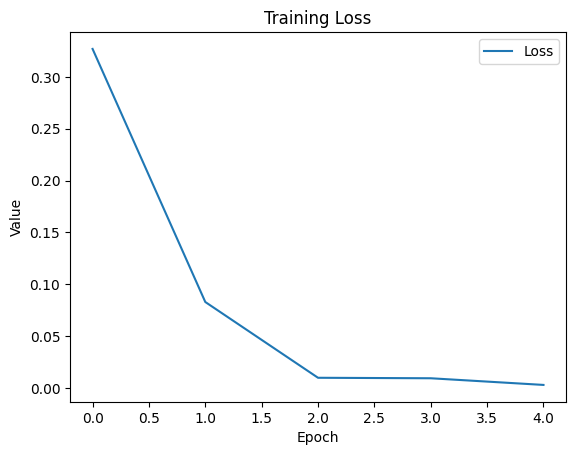

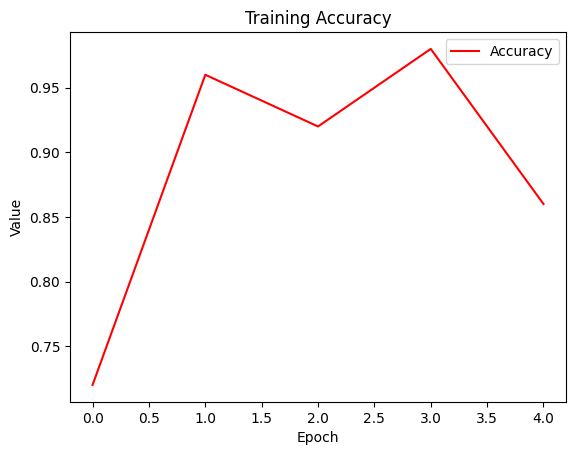

In [15]:
# Experiment 2 b
two_b_net = TwoLayerNetwork(hidden_layer=75)
two_b_loss_list, two_b_acc_list = train(two_b_net, X_train, y_train, X_test, y_test)
graph_loss_acc(two_b_loss_list, two_b_acc_list)

Epoch 0 last loss: 0.4106498062610626, accuracy: 37 / 50 = 0.74
Epoch 1 last loss: 0.05309395119547844, accuracy: 46 / 50 = 0.92
Epoch 2 last loss: 0.021158337593078613, accuracy: 50 / 50 = 1.0
Epoch 3 last loss: 0.04080227389931679, accuracy: 50 / 50 = 1.0
Epoch 4 last loss: 0.030944691970944405, accuracy: 49 / 50 = 0.98


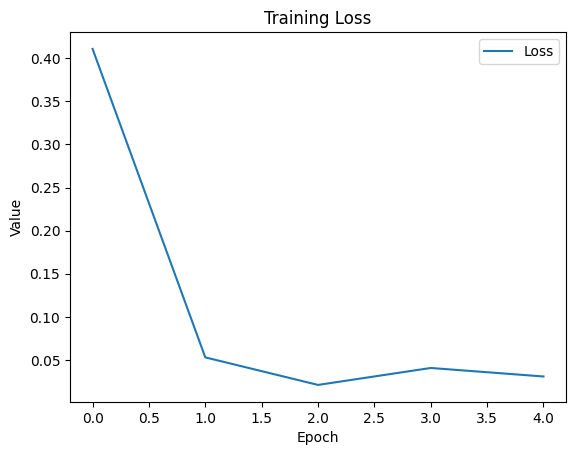

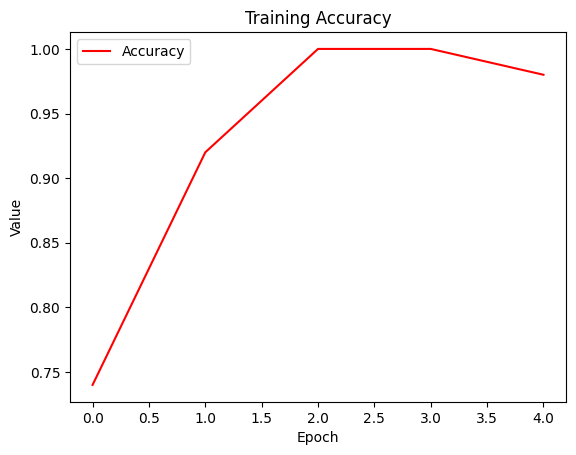

In [16]:
# Experiment 2 c
two_c_net = TwoLayerNetwork(hidden_layer=150)
two_c_loss_list, two_c_acc_list = train(two_c_net, X_train, y_train, X_test, y_test)
graph_loss_acc(two_c_loss_list, two_c_acc_list)

Epoch 0 last loss: 0.4152483642101288, accuracy: 35 / 50 = 0.7
Epoch 1 last loss: 0.3413583040237427, accuracy: 48 / 50 = 0.96
Epoch 2 last loss: 0.03336402401328087, accuracy: 48 / 50 = 0.96
Epoch 3 last loss: 0.05666296184062958, accuracy: 49 / 50 = 0.98
Epoch 4 last loss: 0.04859936609864235, accuracy: 49 / 50 = 0.98


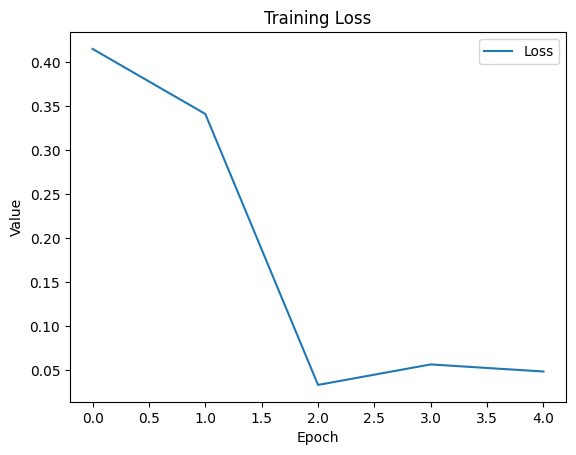

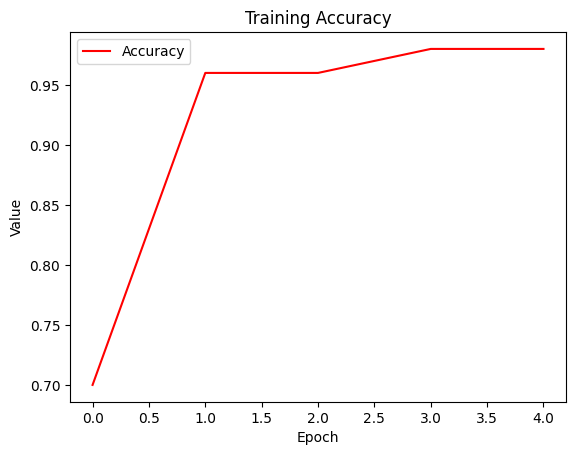

In [17]:
# Experiment 3
five_net = FiveLayerNetwork()
five_loss_list, five_acc_list = train(five_net, X_train, y_train, X_test, y_test)
graph_loss_acc(five_loss_list, five_acc_list)

## Part 2: MNIST Training

Both Keras and PyTorch contain MNIST as built-in dataset, so you can easily get it with a couple of lines of code ([Keras](https://keras.io/api/datasets/mnist/), [PyTorch](https://pytorch.org/vision/stable/datasets.html)). You will also be able to load both train and test datasets without manually splitting them.

In [18]:
from torchvision import datasets
from torchvision.transforms import ToTensor


# Load the dataset

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [19]:
# Define the Neural Network for mnist
class MnistNetwork(torch.nn.Module):
    def __init__(self,hidden_layer=100,func=torch.nn.Sigmoid()):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(28*28,hidden_layer)
        self.func = func
        self.fc2 = torch.nn.Linear(hidden_layer,hidden_layer)
        self.func = func
        self.fc3 = torch.nn.Linear(hidden_layer,10)
        

    def forward(self,x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        x = self.func(x)
        x = self.fc3(x)
        return x

In [23]:
# New train functionality needed
def train(net, dataloader, test_dataloader, epochs = 5, lr = 0.001):
    # Required for calculations
    loss_list = []
    acc_list = []
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for ep in range(epochs):
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            # Predict
            pred = net(X)
            loss = loss_fn(pred, y)

            # Back prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            sum_acc_list = []
            correct = 0
            for batch, (X, y) in enumerate(test_dataloader):
                X, y = X.to(device), y.to(device)
                # Calculate loss and accuracy
                pred = net(X)
                loss = loss_fn(pred, y).item()
    
                class_pred = torch.argmax(pred, axis=1)

                correct = (class_pred == y).sum()
                curr_acc = correct / len(y)
                sum_acc_list.append(curr_acc)
                
            
            # Average loss and epoch accuracy calculations
            acc = sum(sum_acc_list) / len(sum_acc_list)
            print(f"Epoch {ep} last loss: {loss}, average accuracy: {acc}")
            loss_list.append(loss)
            acc_list.append(acc)
    return loss_list, acc_list


In [24]:
mnist_net = MnistNetwork().to(device)
mnist_loss, mnist_acc = train(mnist_net, train_dataloader, test_dataloader)


Epoch 0 last loss: 0.3517082631587982, average accuracy: 0.8218551278114319
Epoch 1 last loss: 0.2417907416820526, average accuracy: 0.8485270738601685
Epoch 2 last loss: 0.19656658172607422, average accuracy: 0.8595740795135498
Epoch 3 last loss: 0.1718207448720932, average accuracy: 0.8652468323707581
Epoch 4 last loss: 0.1525896042585373, average accuracy: 0.8691282272338867


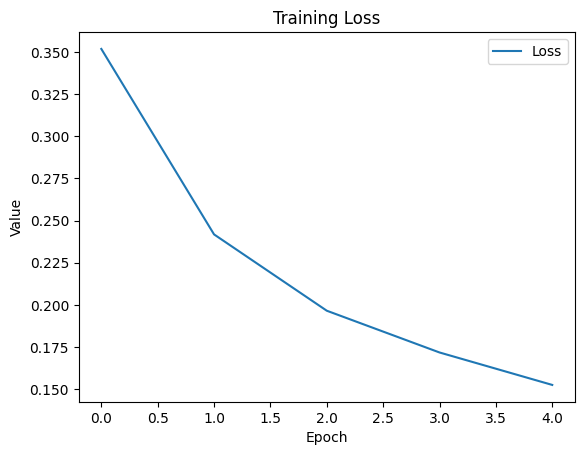

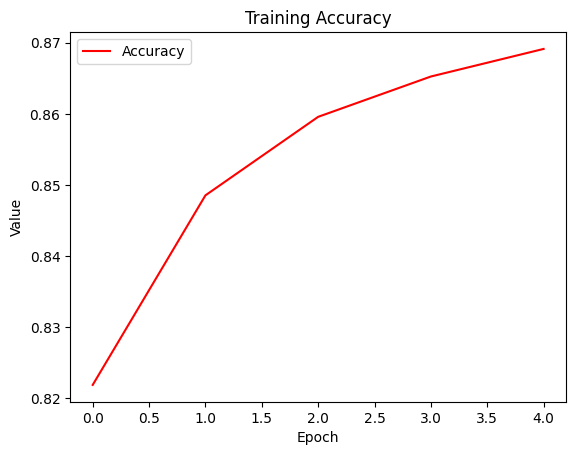

In [25]:
for i in range(len(mnist_acc)):
    mnist_acc[i] = mnist_acc[i].cpu().detach().numpy()
graph_loss_acc(mnist_loss, mnist_acc)


Now you need to perform the steps above to make sure dataset is normalized (it would probably already be), defining and training a neural network.

## Takeaway

1. Neural networks can be used for traditional machine learning tasks. However, they are in many cases too powerful, and can cause overfitting.
1. It is important in this assignment that you observe the overfitting behavior, and try to avoid it.
1. With frameworks like Keras, sometimes training a neural network is quite straightforward. But you need to understand what goes on.